# Understanding the factors influencing COVID-19 vaccination uptake rates in the US


## Models tested:

- `Regularised regression`
- `Random Forest regression`
- `ExtraTreesRegressor`
- `AdaBoostRegressor`
- `Gradient Boosted Decision Trees`

## Final model:

- `ExtraTreesRegressor(n_estimators = 500, max_features = 'auto', max_depth = 15, min_samples_leaf = 3)`

\**Reran after final submission.*

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sklearn
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from xgboost.sklearn import XGBRegressor
from sklearn import preprocessing

In [3]:
base = os.path.split(os.getcwd())[0]
dd = base + '/data/'
df_all = pd.read_csv(dd + 'data_after_imputation.csv')
df_all.columns

Index(['fips', 'state', 'county', 'state_abb', 'pop_full_12plus_per',
       'pop_full_18plus_per', 'pop_full_65plus_per', 'cases_prop',
       'death_prop', 'hesitant_unsure', 'SVI', 'SVI_cat', 'CVAC', 'CVAC_cat',
       'Hispanic (%)', 'non-Hispanic American Indian/Alaska Native (%)',
       'non-Hispanic Asian (%)', 'non-Hispanic Black (%)',
       'non-Hispanic Native Hawaiian/Pacific Islander (%)',
       'non-Hispanic White (%)', 'noHealthInsurance', 'noHighSchool',
       'Poverty', 'logPopDensity', 'Urban_rural_code', 'PrematureDeath',
       'Smoking', 'anycondition_prevalence', 'per_dem', 'per_voted', 'Testing',
       'Traffic', 'DaytimePopDensity', 'ToxPi Score'],
      dtype='object')

<Figure size 2016x1728 with 0 Axes>

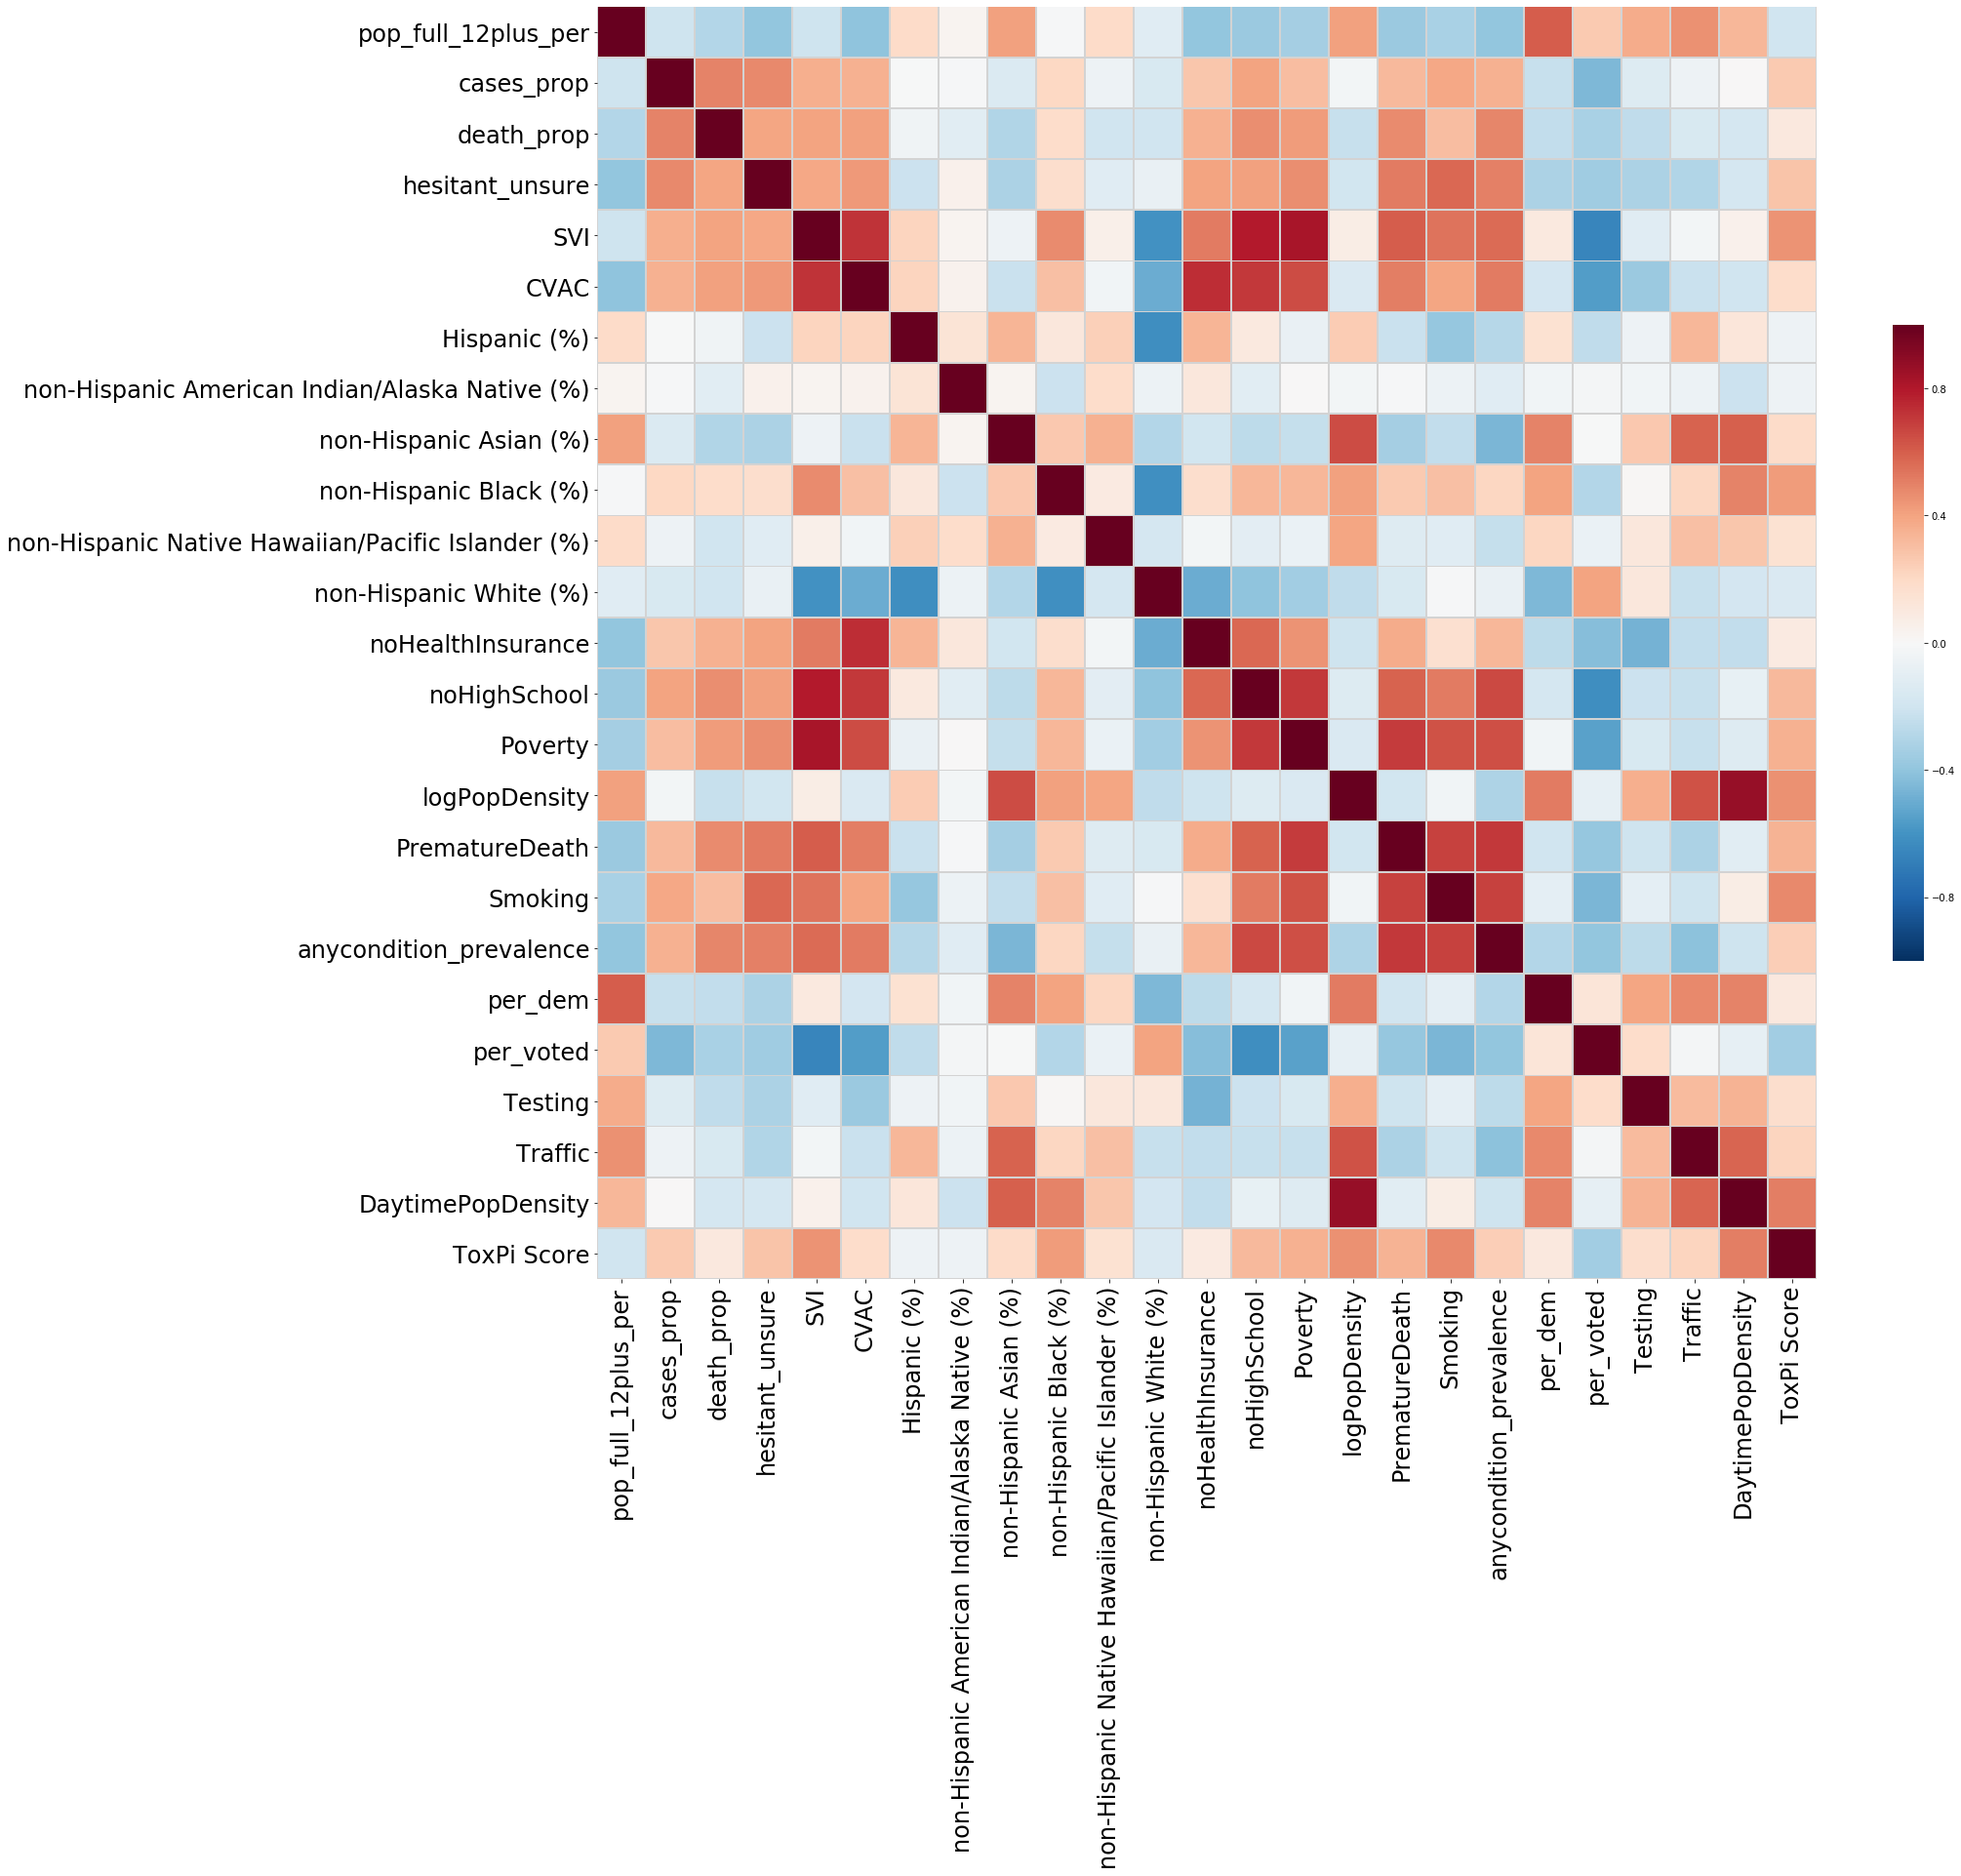

In [3]:
plt.figure(figsize = (28, 24))

full_corr_12 = df_all.select_dtypes(include = ['float64']).drop(columns = ['pop_full_18plus_per',
                               'pop_full_65plus_per']).corr(method = 'spearman')

corr_02 = full_corr_12.where(-((full_corr_12 < 0.2) & (full_corr_12 > -0.2)))

plt.figure(figsize = (28, 24))

color_map = plt.cm.get_cmap('RdBu')
reversed_col = color_map.reversed()

ax = sns.heatmap(full_corr_12, 
                      cmap = reversed_col, linewidths = 0.6,
                      cbar_kws={"shrink": 0.5},
                      vmin = -1, vmax = 1,
                      linecolor = 'lightgrey')
ax.tick_params(axis = 'both', which = 'major', labelsize = 24)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [4]:
df_all.isnull().sum()[df_all.isnull().sum() > 1]

pop_full_12plus_per     55
pop_full_18plus_per    266
pop_full_65plus_per      8
dtype: int64

### Drop `NaN` from target:

In [5]:
df = df_all[df_all['pop_full_12plus_per'].notna()]

## Split data into `train`, `val` and `test` samples.

- keep `fips` for now to be able to explore, which counties were not well predicted.
- predict `pop_full_12plus_per` for now.


- Discuss: `val` sample? `test_size` = ?
- Note dropping categorical features `SVI_cat` and `CVAC_cat`

In [6]:
y = df['pop_full_12plus_per']
X_fips = df.drop(columns = ['state_abb', 'pop_full_12plus_per',
                       'pop_full_18plus_per', 'pop_full_65plus_per',
                       'SVI_cat', 'CVAC_cat'])

# `y_test` - leave until final model has been picked.

In [7]:
X_train_val_fips, X_test_fips, y_train_val, y_test = train_test_split(X_fips, y, test_size = 0.2, random_state = 42)

In [8]:
print('test data shape:', y_test.shape)

test data shape: (611,)


In [9]:
X_train_fips, X_val_fips, y_train, y_val = train_test_split(X_train_val_fips, y_train_val,
                                                           test_size = 0.2, random_state = 42)

In [10]:
print('train data shape:', y_train.shape)
print('val data shape:', y_val.shape)

train data shape: (1953,)
val data shape: (489,)


#### Drop `fips` for modelling

In [11]:
X = X_fips.drop(columns = ['fips','state', 'county'])
X_test = X_test_fips.drop(columns = ['fips','state', 'county'])
X_train = X_train_fips.drop(columns = ['fips','state', 'county'])
X_val = X_val_fips.drop(columns = ['fips','state', 'county'])

-------
# Individual models:

## Ridge Regression:

In [12]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

### Deafault settings base model:

Training data:
Mean Absolute Error: 6.209
Root Mean Squared Error: 8.565



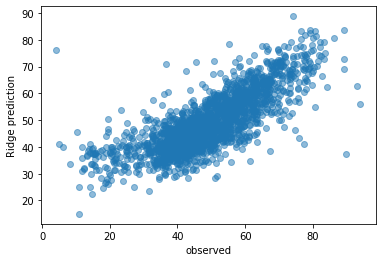

In [13]:
rid = Ridge().fit(X_train_scaled, y_train)
y_train_rid = rid.predict(X_train_scaled)
y_val_rid = rid.predict(X_val_scaled)

print('Training data:')
print('Mean Absolute Error: {:.3f}'.format(mean_absolute_error(y_train, y_train_rid)))  
print('Root Mean Squared Error: {:.3f}'.format(np.sqrt(mean_squared_error(y_train, y_train_rid))))

print()
plt.scatter(y_train,y_train_rid, alpha = 0.5)
plt.xlabel('observed'), plt.ylabel('Ridge prediction')
plt.show()

## Set the optimal `alpha` using `GridSearchCV`:

alpha = 0 OLS

In [14]:
random_grid = {'alpha': list(np.arange(1,20,0.5))}
rid = Ridge()
rid_random = GridSearchCV(estimator = rid, param_grid = random_grid, cv = 5)
rid_random.fit(X_train_scaled, y_train)
rid_random.best_params_

{'alpha': 11.0}

Training
Mean Absolute Error: 6.209
Root Mean Squared Error: 8.565



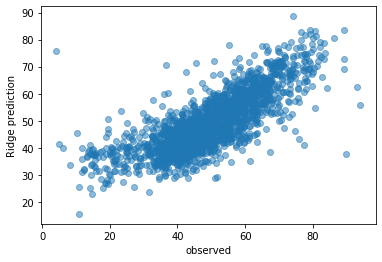

In [15]:
rid_opt = Ridge(alpha = 11).fit(X_train_scaled, y_train)
y_train_rid_opt = rid_opt.predict(X_train_scaled)

print('Training')
print('Mean Absolute Error: {:.3f}'.format(mean_absolute_error(y_train, y_train_rid)))  
print('Root Mean Squared Error: {:.3f}'.format(np.sqrt(mean_squared_error(y_train, y_train_rid))))

print()
plt.scatter(y_train,y_train_rid_opt, alpha = 0.5)
plt.xlabel('observed'), plt.ylabel('Ridge prediction')
plt.show()

validation set:
Rho: Base 0.745165, Opt 0.744752
MAE: Base 6.761848, Opt 6.755700
R2: Base 0.481465, Opt 0.481245
RMSE Base 9.782, opt 9.784


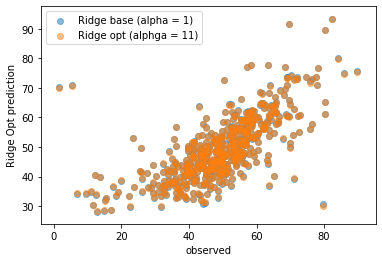

In [16]:
y_val_rid_opt = rid_opt.predict(X_val_scaled)


print('validation set:')
print('Rho: Base {:2f}, Opt {:2f}'.format(spearmanr(y_val,y_val_rid)[0],
                                     spearmanr(y_val,y_val_rid_opt)[0]))
print('MAE: Base {:2f}, Opt {:2f}'.format(mean_absolute_error(y_val,y_val_rid),
                                     mean_absolute_error(y_val,y_val_rid_opt)))
print('R2: Base {:2f}, Opt {:2f}'.format(r2_score(y_val,y_val_rid),
                                     r2_score(y_val,y_val_rid_opt)))
print('RMSE Base {:.3f}, opt {:.3f}'.format(np.sqrt(mean_squared_error(y_val, y_val_rid)),
                                              (np.sqrt(mean_squared_error(y_val, y_val_rid_opt)))))

plt.scatter(y_val,y_val_rid, alpha = 0.5, label = 'Ridge base (alpha = 1)')
plt.scatter(y_val,y_val_rid_opt, alpha = 0.5, label = 'Ridge opt (alphga = 11)')
plt.xlabel('observed'), plt.ylabel('Ridge Opt prediction')
plt.legend()
plt.show()

In [17]:
mae_ridge_opt = mean_absolute_error(y_val,y_val_rid_opt)
rmse_ridge_opt = np.sqrt(mean_squared_error(y_val, y_val_rid_opt))
print(mae_ridge_opt, rmse_ridge_opt)

6.755699747556149 9.784222159774956


----------
## Random Forest Regression:

- No scaling of the data.
- RF might be trickier when combining categorical and continuous data, as RF will give more weight to continuous features especially in calculating the feature_importances. RF is likely to give more weight to parameters with more levels.

- optimise 
    - `n_estimators` (number of random trees), 
    - `max_features` (the number of randomly selected features in each tree, if max_features is close to the total number of features, the trees are more likely to be similar.
    - `max_depth` – the depth of each tree in the ensemble (default=None, splits until all leaves are pure).


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF_base rho: 0.964
R2 score: 0.919
MAE: 2.588
RMSE: 3.923



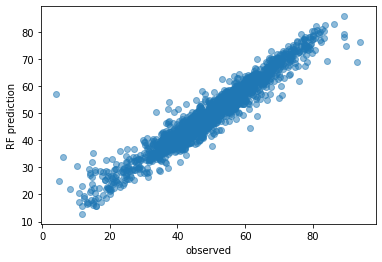

In [18]:
rf_base = RandomForestRegressor()

rf_base.fit(X_train, y_train)
y_train_rf_base = rf_base.predict(X_train)

print('RF_base rho: {:.3f}'.format(spearmanr(y_train,y_train_rf_base)[0]))
print('R2 score: {:.3f}'.format(r2_score(y_train,y_train_rf_base)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_train,y_train_rf_base)))
print('RMSE: {:.3f}'.format(np.sqrt(mean_squared_error(y_train,y_train_rf_base))))
print()
plt.scatter(y_train,y_train_rf_base, alpha = 0.5)
plt.xlabel('observed'), plt.ylabel('RF prediction')
plt.show()

In [19]:
feature_names = X_train.columns

importances = rf_base.feature_importances_

std = np.std([
    tree.feature_importances_ for tree in rf_base.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending = False)

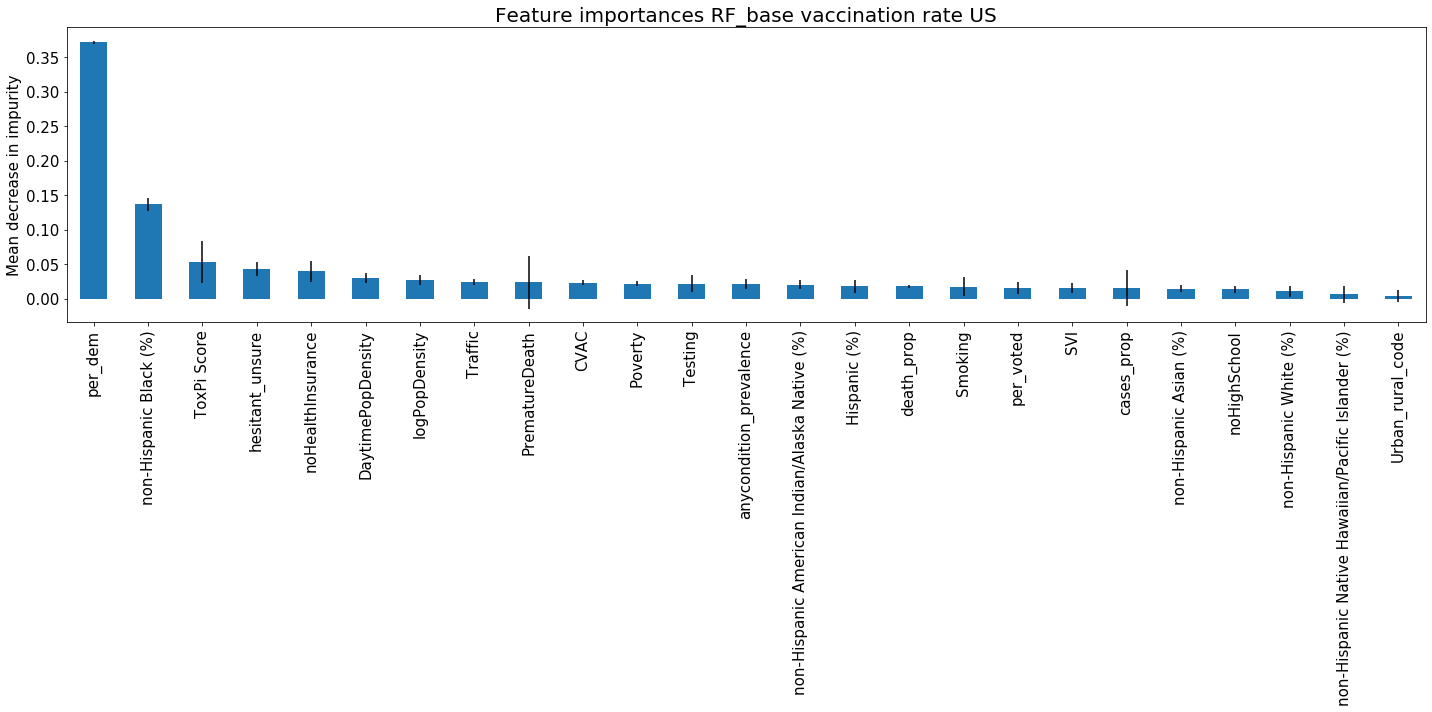

In [20]:
fig, ax = plt.subplots(figsize = (20,10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances RF_base vaccination rate US" , fontsize=20)

ax.set_ylabel("Mean decrease in impurity", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize = 15)

fig.tight_layout()

### Hyperparameters optimisation:

In [22]:
search_param = {'n_estimators': [100, 500, 1000],
               'max_features':('sqrt', 'log2'),
               'max_depth': [5, 15, 20, 25],
               'min_samples_leaf': [1, 5, 10]}

search = GridSearchCV(rf_base, param_grid = search_param,
                     cv = 5, scoring = 'neg_mean_absolute_error', n_jobs = -1)

search.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [5, 15, 20, 25],
       

In [22]:
#print(search.best_params_)
#print(search.best_score_)

RF_base rho: 0.985
R2 score: 0.949
MAE: 2.218
RMSE: 3.093



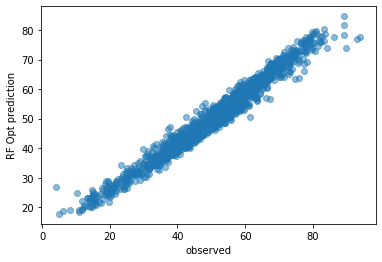

In [23]:
rf_opt = RandomForestRegressor(n_estimators = 500, max_features = 'sqrt', max_depth = 20, 
                              min_samples_leaf = 1)

rf_opt.fit(X_train, y_train)
y_train_rf_opt = rf_opt.predict(X_train)

print('RF_base rho: {:.3f}'.format(spearmanr(y_train,y_train_rf_opt)[0]))
print('R2 score: {:.3f}'.format(r2_score(y_train,y_train_rf_opt)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_train,y_train_rf_opt)))
print('RMSE: {:.3f}'.format(np.sqrt(mean_squared_error(y_train,y_train_rf_opt))))
print()
plt.scatter(y_train,y_train_rf_opt, alpha = 0.5)
plt.xlabel('observed'), plt.ylabel('RF Opt prediction')
plt.show()

Rho: Base 0.753189, Opt 0.795365
MAE: Base 6.590736, Opt 6.098330
R2: Base 0.521798, Opt 0.590175
RMSE: Base 9.394007, Opt 8.696501


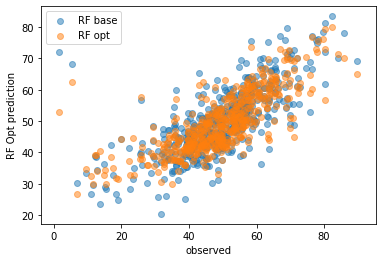

In [24]:
y_val_rf_base = rf_base.predict(X_val)
y_val_rf_opt = rf_opt.predict(X_val)


print('Rho: Base {:2f}, Opt {:2f}'.format(spearmanr(y_val,y_val_rf_base)[0],
                                     spearmanr(y_val,y_val_rf_opt)[0]))
print('MAE: Base {:2f}, Opt {:2f}'.format(mean_absolute_error(y_val,y_val_rf_base),
                                     mean_absolute_error(y_val,y_val_rf_opt)))
print('R2: Base {:2f}, Opt {:2f}'.format(r2_score(y_val,y_val_rf_base),
                                     r2_score(y_val,y_val_rf_opt)))
print('RMSE: Base {:2f}, Opt {:2f}'.format(np.sqrt(mean_squared_error(y_val,y_val_rf_base)),
                                     np.sqrt(mean_squared_error(y_val,y_val_rf_opt))))

plt.scatter(y_val,y_val_rf_base, alpha = 0.5, label = 'RF base')
plt.scatter(y_val,y_val_rf_opt, alpha = 0.5, label = 'RF opt')
plt.xlabel('observed'), plt.ylabel('RF Opt prediction')
plt.legend()
plt.show()

In [25]:
mae_rf_opt = mean_absolute_error(y_val,y_val_rf_opt)
rmse_rf_opt = np.sqrt(mean_squared_error(y_val, y_val_rf_opt))
print(mae_rf_opt, rmse_rf_opt)

6.098329581379574 8.696501067464371


--------
## ExtraTreesRegressor

training data
ETR_base rho: 1.000
R2 score: 1.000
MAE: 0.000
RMSE: 0.000



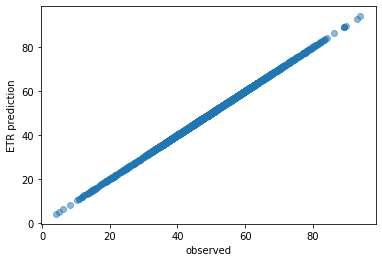

In [26]:
etr_base = ExtraTreesRegressor(n_estimators = 1000)

etr_base.fit(X_train, y_train)
y_train_etr_base = etr_base.predict(X_train)

print('training data')
print('ETR_base rho: {:.3f}'.format(spearmanr(y_train,y_train_etr_base)[0]))
print('R2 score: {:.3f}'.format(r2_score(y_train,y_train_etr_base)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_train,y_train_etr_base)))
print('RMSE: {:.3f}'.format(np.sqrt(mean_squared_error(y_train,y_train_etr_base))))

print()

plt.scatter(y_train, y_train_etr_base, alpha = 0.5)
plt.xlabel('observed'), plt.ylabel('ETR prediction')
plt.show()

In [42]:
search_param = {'max_depth': [5, 10, 15],
               'n_estimators': [100, 500, 1000],
               'max_features': ('sqrt'),
               'min_samples_leaf': [3, 5, 10]}


etr = ExtraTreesRegressor()
etr_random = GridSearchCV(estimator = etr, param_grid = search_param, 
                          cv = 5, n_jobs = -1)
etr_random.fit(X_train, y_train)

print(etr_random.best_params_)
print(etr_random.best_score_)

{'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 3, 'n_estimators': 500}
0.6431925695493521


ETR_base rho: 0.979
R2 score: 0.939
MAE: 2.263
RMSE: 3.404



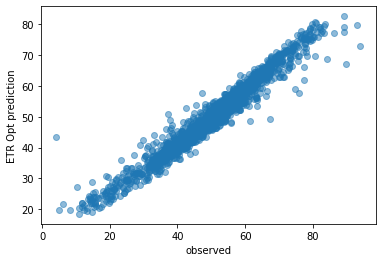

In [27]:
etr_opt = ExtraTreesRegressor(n_estimators = 500, max_features = 'auto', max_depth = 15, 
                              min_samples_leaf = 3)

etr_opt.fit(X_train, y_train)
y_train_etr_opt = etr_opt.predict(X_train)

print('ETR_base rho: {:.3f}'.format(spearmanr(y_train,y_train_etr_opt)[0]))
print('R2 score: {:.3f}'.format(r2_score(y_train,y_train_etr_opt)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_train,y_train_etr_opt)))
print('RMSE: {:.3f}'.format(np.sqrt(mean_squared_error(y_train,y_train_etr_opt))))
print()
plt.scatter(y_train,y_train_etr_opt, alpha = 0.5)
plt.xlabel('observed'), plt.ylabel('ETR Opt prediction')
plt.show()

In [28]:
feature_names = X_train.columns
importances = etr_opt.feature_importances_

std = np.std([
    tree.feature_importances_ for tree in etr_opt.estimators_], axis=0)

forest_importances = pd.Series(importances, index = feature_names).sort_values(ascending = False)
top_10 = forest_importances[:10]

In [29]:
top_10.rename({'per_dem': 'Democratic voters 2020 (%)',
               'hesitant_unsure': 'hesitant or unsure about vaccination (%)',
               'logPopDensity': 'Population Density (log)',
               'ToxPi Score': 'PVI score',
               'noHealthInsurance': 'no Health Insurance (%)',
               'noHighSchool': 'no High schools education (25yo+) (%)',
               'anycondition_prevalence': 'Prevalence medical conditions'}, inplace = True)

mapping = {'pop_full_12plus_per': 'Fully vaccinated 12yo+ (%)',
          'cases_prop': 'Covid-19 infection cases (%)',
          'death_prop': 'Covid-19 related deaths (%)',
          'hesitant_unsure': 'hesitant or unsure about vaccination (%)',
          'noHealthInsurance': 'no Health Insurance (%)',
          'noHighSchool': 'no High schools education (25yo+) (%)',
          'Poverty': 'living in poverty (%)',
          'logPopDensity': 'Population Density (log)',
          'anycondition_prevalence': 'Prevalence medical conditions',
          'per_dem': 'Democratic voters 2020 (%)',
          'per_voted': 'voted in 2020 (%)',
          'ToxPi Score': 'PVI'}

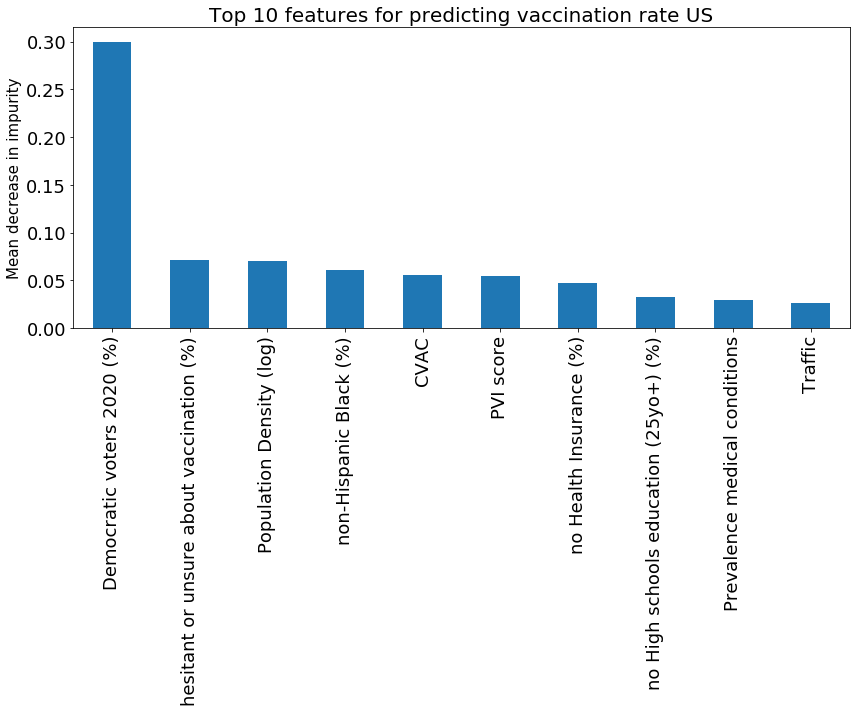

In [50]:
fig, ax = plt.subplots(figsize = (12,10))
top_10.plot.bar(ax = ax)

ax.set_title("Top 10 features for predicting vaccination rate US" , fontsize=20)
ax.set_ylabel("Mean decrease in impurity", fontsize = 15)
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)

fig.tight_layout()
plt.savefig(dd + './plots/final_model_top10features_12plus.png', bbox_inches = 'tight', dpi = 300)

Rho: Base 0.810857, Opt 0.800886
MAE: Base 5.824435, Opt 5.928963
R2: Base 0.626752, Opt 0.598741
RMSE: Base 8.299344, Opt 8.605137


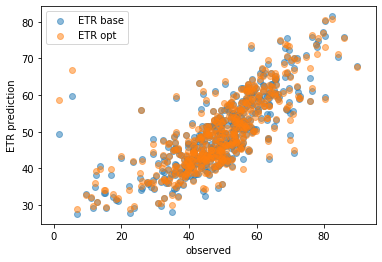

In [31]:
y_val_etr_base = etr_base.predict(X_val)
y_val_etr_opt = etr_opt.predict(X_val)


print('Rho: Base {:2f}, Opt {:2f}'.format(spearmanr(y_val,y_val_etr_base)[0],
                                     spearmanr(y_val,y_val_etr_opt)[0]))
print('MAE: Base {:2f}, Opt {:2f}'.format(mean_absolute_error(y_val,y_val_etr_base),
                                     mean_absolute_error(y_val,y_val_etr_opt)))
print('R2: Base {:2f}, Opt {:2f}'.format(r2_score(y_val,y_val_etr_base),
                                     r2_score(y_val,y_val_etr_opt)))
print('RMSE: Base {:2f}, Opt {:2f}'.format(np.sqrt(mean_squared_error(y_val,y_val_etr_base)),
                                     np.sqrt(mean_squared_error(y_val,y_val_etr_opt))))

plt.scatter(y_val,y_val_etr_base, alpha = 0.5, label = 'ETR base')
plt.scatter(y_val,y_val_etr_opt, alpha = 0.5, label = 'ETR opt')
plt.xlabel('observed'), plt.ylabel('ETR prediction')
plt.legend()
plt.show()

In [32]:
mae_etr_opt = mean_absolute_error(y_val,y_val_etr_opt)
rmse_etr_opt = np.sqrt(mean_squared_error(y_val, y_val_etr_opt))
print(mae_etr_opt, rmse_etr_opt)

5.928962740225586 8.605136890686177


---------
## AdaBoostRegressor

training data
ETR_base rho: 0.774
R2 score: 0.604
MAE: 6.942
RMSE: 8.662



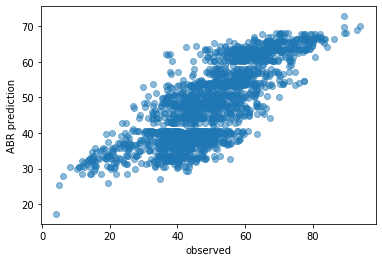

In [33]:
abr_base = AdaBoostRegressor()

abr_base.fit(X_train, y_train)
y_train_abr_base = abr_base.predict(X_train)

print('training data')
print('ETR_base rho: {:.3f}'.format(spearmanr(y_train,y_train_abr_base)[0]))
print('R2 score: {:.3f}'.format(r2_score(y_train,y_train_abr_base)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_train,y_train_abr_base)))
print('RMSE: {:.3f}'.format(np.sqrt(mean_squared_error(y_train,y_train_abr_base))))
print()

plt.scatter(y_train,y_train_abr_base, alpha = 0.5)
plt.xlabel('observed'), plt.ylabel('ABR prediction')
plt.show()

In [53]:
search_param = {'n_estimators':[10,50,250,1000],
                'learning_rate':[0.01,0.05,0.1]}

abr = AdaBoostRegressor()
abr_random = GridSearchCV(abr, param_grid = search_param, cv = 5,
                          scoring='neg_mean_absolute_error', n_jobs = -1)

abr_random.fit(X_train, y_train)

print(abr_random.best_params_)
print(abr_random.best_score_)

{'learning_rate': 0.01, 'n_estimators': 1000}
-7.054193547568077


RF_base rho: 0.789
R2 score: 0.598
MAE: 6.688
RMSE: 8.726



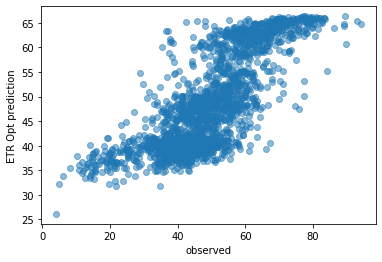

In [34]:
abr_opt = AdaBoostRegressor(n_estimators = 1000, learning_rate = 0.01)

abr_opt.fit(X_train, y_train)
y_train_abr_opt = abr_opt.predict(X_train)

print('RF_base rho: {:.3f}'.format(spearmanr(y_train,y_train_abr_opt)[0]))
print('R2 score: {:.3f}'.format(r2_score(y_train,y_train_abr_opt)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_train,y_train_abr_opt)))
print('RMSE: {:.3f}'.format(np.sqrt(mean_squared_error(y_train,y_train_abr_opt))))
print()

plt.scatter(y_train,y_train_abr_opt, alpha = 0.5)
plt.xlabel('observed'), plt.ylabel('ETR Opt prediction')
plt.show()

Rho: Base 0.722255, Opt 0.730179
MAE: Base 7.485935, Opt 7.294355
R2: Base 0.451282, Opt 0.456802
RMSE: Base 10.062823, Opt 10.012081


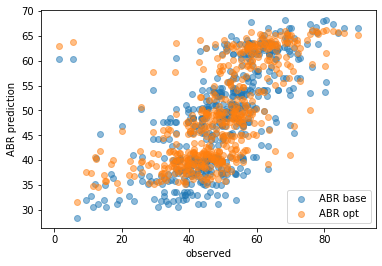

In [35]:
y_val_abr_base = abr_base.predict(X_val)
y_val_abr_opt = abr_opt.predict(X_val)


print('Rho: Base {:2f}, Opt {:2f}'.format(spearmanr(y_val,y_val_abr_base)[0],
                                     spearmanr(y_val,y_val_abr_opt)[0]))
print('MAE: Base {:2f}, Opt {:2f}'.format(mean_absolute_error(y_val,y_val_abr_base),
                                     mean_absolute_error(y_val,y_val_abr_opt)))
print('R2: Base {:2f}, Opt {:2f}'.format(r2_score(y_val,y_val_abr_base),
                                     r2_score(y_val,y_val_abr_opt)))
print('RMSE: Base {:2f}, Opt {:2f}'.format(np.sqrt(mean_squared_error(y_val,y_val_abr_base)),
                                     np.sqrt(mean_squared_error(y_val,y_val_abr_opt))))

plt.scatter(y_val,y_val_abr_base, alpha = 0.5, label = 'ABR base')
plt.scatter(y_val,y_val_abr_opt, alpha = 0.5, label = 'ABR opt')

plt.xlabel('observed'), plt.ylabel('ABR prediction')
plt.legend()
plt.show()

In [36]:
mae_abr_opt = mean_absolute_error(y_val,y_val_abr_opt)
rmse_abr_opt = np.sqrt(mean_squared_error(y_val, y_val_abr_opt))
print(mae_abr_opt, rmse_abr_opt)

7.2943547772167765 10.012081390836943


-----------
## Gradient Boosted Decision Trees

- `n_estimators` specifies how many times to go through the modeling cycle described above. It is equal to the number of models that we include in the ensemble. Too low a value causes underfitting, which leads to inaccurate predictions on both training data and test data. Too high a value causes overfitting, which causes accurate predictions on training data, but inaccurate predictions on test data (which is what we care about). Typical values range from 100-1000, though this depends a lot on the learning_rate parameter discussed below.

- `early_stopping_rounds` offers a way to automatically find the ideal value for `n_estimators`. Early stopping causes the model to stop iterating when the validation score stops improving, even if we aren't at the hard stop for n_estimators. It's smart to set a high value for n_estimators and then use early_stopping_rounds to find the optimal time to stop iterating. Since random chance sometimes causes a single round where validation scores don't improve, you need to specify a number for how many rounds of straight deterioration to allow before stopping. Setting early_stopping_rounds=5 is a reasonable choice. In this case, we stop after 5 straight rounds of deteriorating validation scores.

- `learning_rate` - Instead of getting predictions by simply adding up the predictions from each component model, we can multiply the predictions from each model by a small number (known as the learning rate) before adding them in. This means each tree we add to the ensemble helps us less. So, we can set a higher value for n_estimators without overfitting. If we use early stopping, the appropriate number of trees will be determined automatically. In general, a small learning rate and large number of estimators will yield more accurate XGBoost models, though it will also take the model longer to train since it does more iterations through the cycle. As default, XGBoost sets learning_rate=0.1.

In [37]:
from xgboost import XGBRegressor #, plot_importance

/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:12:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
training data
ETR_base rho: 0.887
R2 score: 0.791
MAE: 4.692
RMSE: 6.295



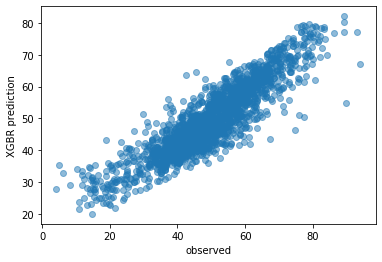

In [38]:
xgbr_base = XGBRegressor() 

xgbr_base.fit(X_train, y_train)
y_train_xgbr_base = xgbr_base.predict(X_train)

print('training data')
print('ETR_base rho: {:.3f}'.format(spearmanr(y_train,y_train_xgbr_base)[0]))
print('R2 score: {:.3f}'.format(r2_score(y_train,y_train_xgbr_base)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_train,y_train_xgbr_base)))
print('RMSE: {:.3f}'.format(np.sqrt(mean_squared_error(y_train,y_train_xgbr_base))))
print()

plt.scatter(y_train, y_train_xgbr_base, alpha = 0.5)
plt.xlabel('observed'), plt.ylabel('XGBR prediction')
plt.show()

In [ ]:
search_param = {'n_estimators': [500, 750],
                'learning_rate': [0.05, 0.1],
                'max_depth': [3, 4, 5, 6],
                'early_stopping_rounds': [4, 5]
                #'subsample': [0.75, 1.0]
               }

search = GridSearchCV(xgbr_base, param_grid = search_param,
                     cv = 5, scoring = 'neg_mean_absolute_error')

search.fit(X_train, y_train)

In [90]:
print(search.best_params_)
print(search.best_score_)

{'early_stopping_rounds': 4, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 500}
-5.899698688235579


/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:13:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RF_base rho: 0.893
R2 score: 0.801
MAE: 4.610
RMSE: 6.145



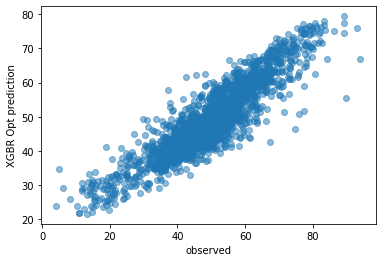

In [39]:
xgbr_opt = XGBRegressor(n_estimators = 500, learning_rate = 0.01, max_depth = 4, early_stopping_rounds = 4)

xgbr_opt.fit(X_train, y_train)
y_train_xgbr_opt = xgbr_opt.predict(X_train)

print('RF_base rho: {:.3f}'.format(spearmanr(y_train,y_train_xgbr_opt)[0]))
print('R2 score: {:.3f}'.format(r2_score(y_train,y_train_xgbr_opt)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_train,y_train_xgbr_opt)))
print('RMSE: {:.3f}'.format(np.sqrt(mean_squared_error(y_train,y_train_xgbr_opt))))
print()

plt.scatter(y_train,y_train_xgbr_opt, alpha = 0.5)
plt.xlabel('observed'), plt.ylabel('XGBR Opt prediction')
plt.show()

Rho: Base 0.786272, Opt 0.779547
MAE: Base 6.247495, Opt 6.383643
R2: Base 0.583366, Opt 0.573281
RMSE: Base 8.768447, Opt 8.873930


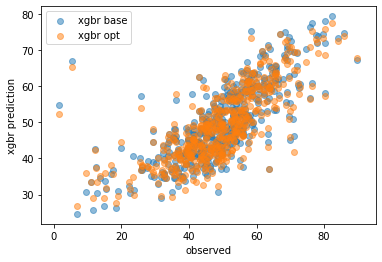

In [40]:
y_val_xgbr_base = xgbr_base.predict(X_val)
y_val_xgbr_opt = xgbr_opt.predict(X_val)


print('Rho: Base {:2f}, Opt {:2f}'.format(spearmanr(y_val,y_val_xgbr_base)[0],
                                     spearmanr(y_val,y_val_xgbr_opt)[0]))
print('MAE: Base {:2f}, Opt {:2f}'.format(mean_absolute_error(y_val,y_val_xgbr_base),
                                     mean_absolute_error(y_val,y_val_xgbr_opt)))
print('R2: Base {:2f}, Opt {:2f}'.format(r2_score(y_val,y_val_xgbr_base),
                                     r2_score(y_val,y_val_xgbr_opt)))
print('RMSE: Base {:2f}, Opt {:2f}'.format(np.sqrt(mean_squared_error(y_val,y_val_xgbr_base)),
                                     np.sqrt(mean_squared_error(y_val,y_val_xgbr_opt))))

plt.scatter(y_val,y_val_xgbr_base, alpha = 0.5, label = 'xgbr base')
plt.scatter(y_val,y_val_xgbr_opt, alpha = 0.5, label = 'xgbr opt')

plt.xlabel('observed'), plt.ylabel('xgbr prediction')
plt.legend()
plt.show()

In [41]:
mae_xgbr_opt = mean_absolute_error(y_val,y_val_xgbr_opt)
rmse_xgbr_opt = np.sqrt(mean_squared_error(y_val, y_val_xgbr_opt))
print(mae_xgbr_opt, rmse_xgbr_opt)

6.383642980657473 8.87392991752331


In [42]:
models = ['ridge', 'RF', 'ETR','Ada','XGBR']
mae = [mae_ridge_opt, mae_rf_opt, mae_etr_opt, mae_abr_opt, mae_xgbr_opt]
rmse = [rmse_ridge_opt, rmse_rf_opt, rmse_etr_opt, rmse_abr_opt, rmse_xgbr_opt]

In [47]:
print(mae)
print(rmse)

[6.755699747556149, 6.098329581379574, 5.928962740225586, 7.2943547772167765, 6.383642980657473]
[9.784222159774956, 8.696501067464371, 8.605136890686177, 10.012081390836943, 8.87392991752331]


--------------

# Final prediction of vaccination rate in `y_test` using Extra Tree Regression:

In [12]:
X_train_val = X_train_val_fips.drop(columns = ['fips','state', 'county'])

In [13]:
etr_opt = ExtraTreesRegressor(n_estimators = 500, max_features = 'auto', max_depth = 15, 
                              min_samples_leaf = 3)
etr_opt.fit(X_train_val, y_train_val)
y_t = etr_opt.predict(X_test)

print('Rho: {:2f}'.format(spearmanr(y_test,y_t)[0]))
print('MAE: {:2f}'.format(mean_absolute_error(y_test,y_t)))
print('R2: {:2f},'.format(r2_score(y_test,y_t)))
print('RMSE: {:2f}'.format(np.sqrt(mean_squared_error(y_test,y_t))))

Rho: 0.812427
MAE: 6.122982
R2: 0.651290,
RMSE: 8.488545


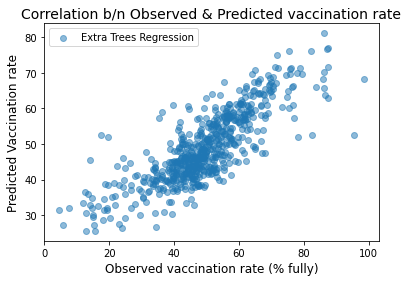

In [14]:
plt.scatter(y_test,y_t, alpha = 0.5, label = 'Extra Trees Regression')
plt.xlabel('Observed vaccination rate (% fully)', fontsize = 12)
plt.ylabel('Predicted Vaccination rate', fontsize = 12)
plt.title('Correlation b/n Observed & Predicted vaccination rate', fontsize = 14)
plt.legend()
plt.show()

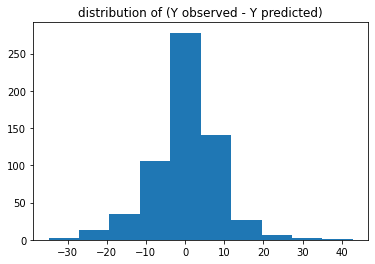

In [15]:
plt.hist(y_test-y_t)
plt.title('distribution of (Y observed - Y predicted)')
plt.show()

In [16]:
mapping = {'pop_full_12plus_per': 'Fully vaccinated 12yo+ (%)',
          'cases_prop': 'Covid-19 infection cases (%)',
          'death_prop': 'Covid-19 related deaths (%)',
          'hesitant_unsure': 'hesitant or unsure about vaccination (%)',
          'noHealthInsurance': 'no Health Insurance (%)',
          'noHighSchool': 'no High schools education (25yo+) (%)',
          'Poverty': 'living in poverty (%)',
          'logPopDensity': 'Population Density (log)',
          'anycondition_prevalence': 'Prevalence medical conditions',
          'per_dem': 'Democratic voters 2020 (%)',
          'per_voted': 'voted in 2020 (%)',
          'ToxPi Score': 'PVI'}
X_train_val = X_train_val.rename(columns = mapping)
X_test = X_test.rename(columns = mapping)

# Permutation Importance on final model

Permutation importances can be computed either on the training set or on a held-out testing or validation set. Using a held-out set makes it possible to highlight which features contribute the most to the generalization power of the inspected model. Features that are important on the training set but not on the held-out set might cause the model to overfit.

In [17]:
from sklearn.inspection import permutation_importance

### On Test Set

In [18]:
etr_opt = ExtraTreesRegressor(n_estimators = 500, max_features = 'auto', max_depth = 15, 
                              min_samples_leaf = 3)
etr_opt.fit(X_train_val, y_train_val)

result = permutation_importance(etr_opt, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [19]:
sorted_idx

array([ 9, 23,  7, 22,  3,  1,  0, 15, 20, 16, 13,  5, 10, 12, 21, 18,  6,
       17,  4, 14, 11,  8,  2, 24, 19])

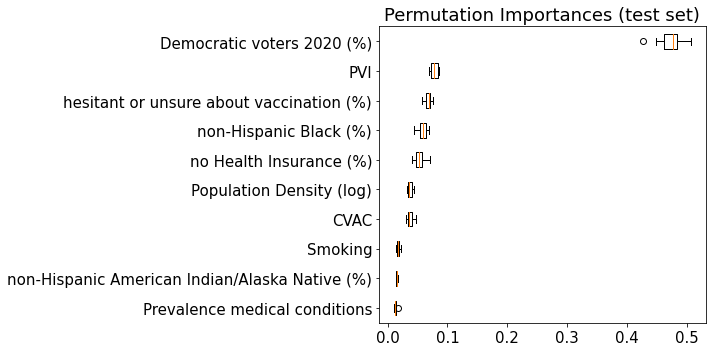

In [32]:
sorted_idx_10 = sorted_idx[-10:]

plt.rcParams["figure.figsize"] = (10,5)
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx_10].T,
           vert = False, labels = X_test.columns[sorted_idx_10])
ax.set_title("Permutation Importances (test set)", fontsize = 18)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
fig.tight_layout()
#plt.savefig('../data/plots/' + 'perm_imp_test.png', dpi = 300)
plt.show()

### On Training data 

In [21]:
result_1 = permutation_importance(etr_opt, X_train_val, y_train_val, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx_1 = result_1.importances_mean.argsort()

/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


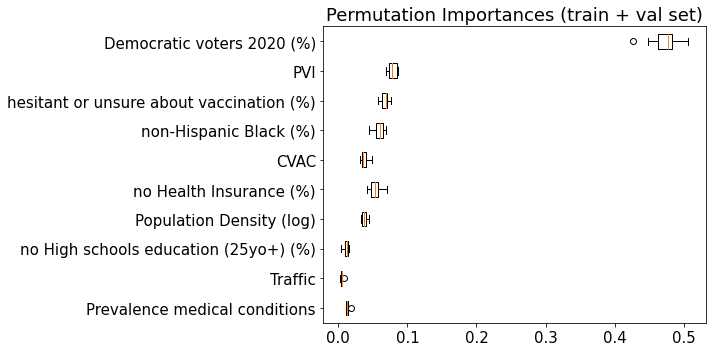

In [33]:
sorted_idx_1_10 = sorted_idx_1[-10:]

plt.rcParams["figure.figsize"] = (10,5)
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx_1_10].T,
           vert = False, labels = X_test.columns[sorted_idx_1_10])
ax.set_title("Permutation Importances (train + val set)", fontsize = 18)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
fig.tight_layout()
#plt.savefig('../data/plots/' + 'perm_imp_train_val.png', dpi = 300)
plt.show()

## SHAP on test set

If a feature has medium permutation importance, that could mean it has a large effect for a few predictions, but no effect in general, or a medium effect for all predictions.
SHAP summary plots give us a birds-eye view of feature importance and what is driving it. 

etr_opt contains data about the training_val set that it was built on, so TreeExplainer uses that for computing conditional expectations. You pass to explainer.shap_values whatever samples you want to explain - we start with test set

In [31]:
import shap

# Create object that can calculate shap values
explainer = shap.TreeExplainer(etr_opt)

# Calculate Shap values
shap_values = explainer.shap_values(X_test)

- 611: SHAP values for every datapoint 
- 25: SHAP value contributions for every feature

In [34]:
shap_values.shape

(611, 25)

### Interactive Plot

In blue, we have negative Shap values that show everything that pushes the sales value in the negative direction. While the Shap value in red represents everything that pushes it towards a positive direction.

Stacked SHAP explanations clustered by explanation similarity. Each position on the x-axis is an instance of the data. Red SHAP values increase the prediction, blue values decrease it. A cluster stands out:

SHAP clustering works by clustering on Shapley values of each instance. This means that you cluster instances by explanation similarity. All SHAP values have the same unit – the unit of the prediction space. You can use any clustering method. The following example uses hierarchical agglomerative clustering to order the instances.

The plot consists of many force plots, each of which explains the prediction of an instance. We rotate the force plots vertically and place them side by side according to their clustering similarity.

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test)

This shows the Shap values on the x-axis. Here, all the values on the left represent the observations that shift the predicted value in the negative direction while the points on the right contribute to shifting the prediction in a positive direction. All the features are on the left y-axis.m

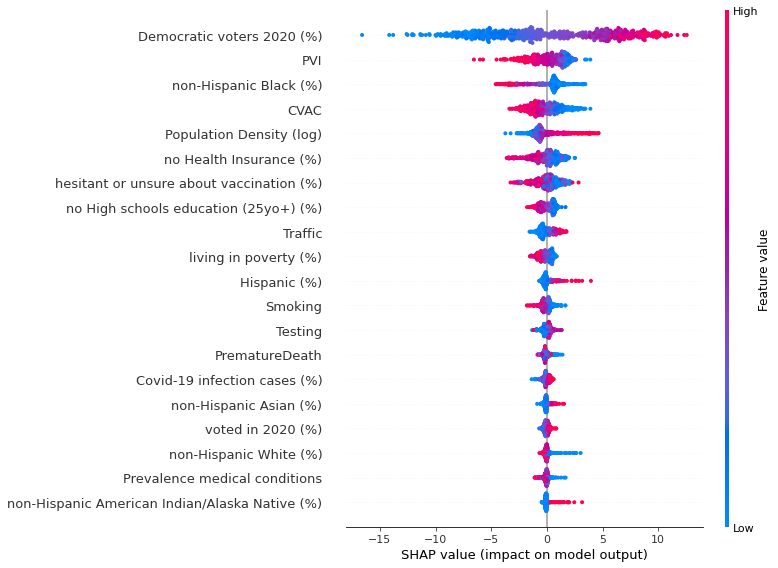

In [39]:
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns, show=False)
# plt.savefig('../data/plots/' + 'shap_summary_plot.png', bbox_inches='tight')

most influential features based on SHAP contributions are per_dem,ToxPi Score non Hispanic Black

In [37]:
X_test.columns

Index(['Covid-19 infection cases (%)', 'Covid-19 related deaths (%)',
       'hesitant or unsure about vaccination (%)', 'SVI', 'CVAC',
       'Hispanic (%)', 'non-Hispanic American Indian/Alaska Native (%)',
       'non-Hispanic Asian (%)', 'non-Hispanic Black (%)',
       'non-Hispanic Native Hawaiian/Pacific Islander (%)',
       'non-Hispanic White (%)', 'no Health Insurance (%)',
       'no High schools education (25yo+) (%)', 'living in poverty (%)',
       'Population Density (log)', 'Urban_rural_code', 'PrematureDeath',
       'Smoking', 'Prevalence medical conditions',
       'Democratic voters 2020 (%)', 'voted in 2020 (%)', 'Testing', 'Traffic',
       'DaytimePopDensity', 'PVI'],
      dtype='object')

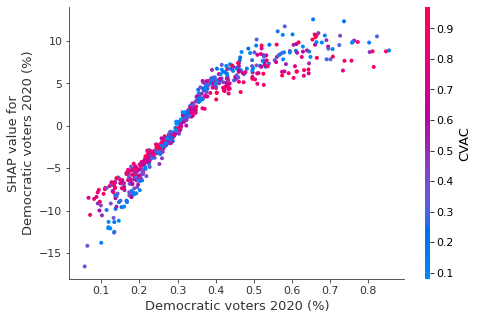

In [40]:
shap.dependence_plot('Democratic voters 2020 (%)', shap_values, X_test, show = False)
#plt.savefig('../data/plots/' + 'SHAP_interaction_plot1.png', dpi = 300)

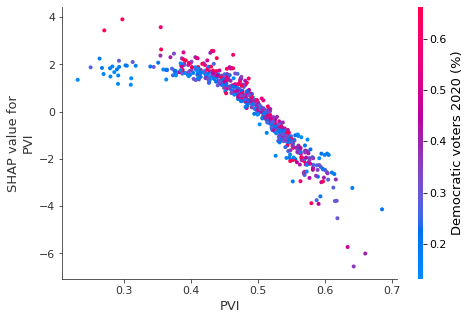

In [41]:
shap.dependence_plot("PVI", shap_values, X_test, show = False)
#plt.savefig('../data/plots/' + 'SHAP_interaction_plot2.png', dpi = 300)

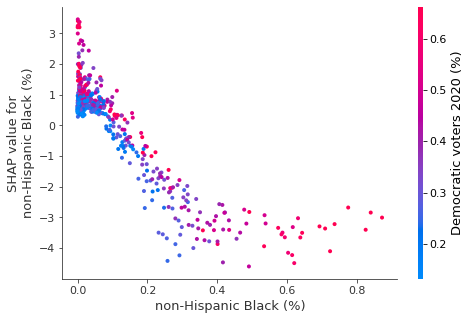

In [42]:
shap.dependence_plot("non-Hispanic Black (%)", shap_values, X_test, interaction_index = 'Democratic voters 2020 (%)',
                    show = False)
#plt.savefig('../data/plots/' + 'SHAP_interaction_plot3.png', dpi = 300)

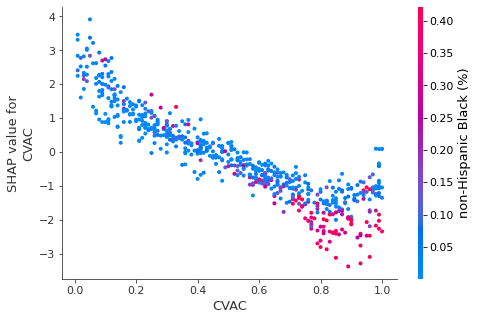

In [43]:
shap.dependence_plot("CVAC", shap_values, X_test, show = False)
#plt.savefig('../data/plots/' + 'SHAP_interaction_plot4.png', dpi = 300)

-----------------------

## Which counties had high error?

In [51]:
d = {'obs': y_test.values,
    'pred': y_t}
test_pred = pd.DataFrame(data = d)
test_pred['error'] = test_pred['obs'] - test_pred['pred']

In [1]:
#df_test = pd.concat( [X_test_fips.reset_index(drop = True), test_pred.reset_index(drop = True)], axis=1)
#df_test.head(n = 3)

In [2]:
#df_test[abs(df_test['error']) > 30]

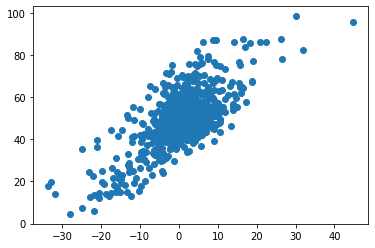

In [61]:
plt.scatter(df_test['error'], df_test['obs'])

In [71]:
# df_test.to_csv(dd + '/test_prediction.csv', index = False)